In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

In [2]:
df_write = pd.read_csv('time_write_value_cycles_10000_delay_0.csv')
df_method = pd.read_csv('time_method_cycles_10000_delay_0.csv')
df_sub = pd.read_csv('time_subscription_cycles_10000_period_10_queuesize_1.csv')

In [3]:
def gauß(x, mu, std, a):
    return (a/np.sqrt(2*np.pi*std**2))*np.exp(-((x-mu)**2)/2*std**2)

def log_norm(x, m, s, a):
    return (a/np.sqrt(2*np.pi)*s*x)*np.exp(-((np.log(x)-m**2)/2*s**2))

def rayleigh(x, mu, std):
    return (x/std**2)*np.exp(-(x-mu**2)/2*std**2)


def draw_quantile(data, quantile, linestyles=None, ax=None):
    if linestyles:
        for idx,q in enumerate(quantile):
            plt.axvline(x=np.quantile(data, q), color='k', label=f'{q*100}%', linestyle=linestyles[idx]) 
    else:
        for q in quantile:
            plt.axvline(x=np.quantile(data, q), color='k', label=f'{q*100}%')
            
def plot_cdf(data, end=1, num=10, plot=True):
    steps = np.linspace(0, end, num)
    data_mat, steps_mat = np.meshgrid(data, steps)
    cdf = np.array(list(map(np.quantile, data_mat, steps)))
    if plot: plt.plot(cdf, steps*100)
    return cdf, steps

In [4]:
# bins = np.linspace(0,40, 200)

# plot_hist(df_write['write_value']*10**(-6), bins, title=f'write value {len(df_write)} calls')
# plt.xlabel('execution time [ms]')
# plt.show()

# plot_hist(df_method['method_call']*10**(-6), bins, title=f'method call {len(df_method)} calls')
# plt.xlabel('execution time [ms]')
# plt.show()

# plot_hist(df_sub['datachange_notifications']*10**(-6), bins, title=f'{len(df_method)} datachange notifications')
# plt.xlabel('notifications time intervall [ms]')
# plt.show()

# bins = np.linspace(-10,20, 200)
# plot_hist(df_sub['datachange_notifications']*10**(-6)-df_sub['period'], bins,
#           title=f'{len(df_method)} datachange notifications')
# plt.xlabel('notifications time intervall - peroid [ms]')
# plt.show()

In [5]:
# df_write = pd.read_csv('time_write_value_cycles_10000_delay_0.csv')
# df_method = pd.read_csv('time_method_cycles_10000_delay_0.csv')
# df_sub = pd.read_csv('time_subscription_cycles_10000_period_10_queuesize_1.csv')

# bins = np.linspace(0,40, 41)

# plot_hist(df_write['write_value']*10**(-6), bins, title=f'write value {len(df_write)} calls')
# plt.xlabel('execution time [ms]')
# plt.show()

# plot_hist(df_method['method_call']*10**(-6), bins, title=f'method call {len(df_method)} calls')
# plt.xlabel('execution time [ms]')
# plt.show()

# plot_hist(df_sub['datachange_notifications']*10**(-6), bins, title=f'{len(df_method)} datachange notifications')
# plt.xlabel('notifications time intervall [ms]')
# plt.show()

# bins = np.linspace(-10,20, 31)
# plot_hist(df_sub['datachange_notifications']*10**(-6)-df_sub['period'], bins,
#           title=f'{len(df_method)} datachange notifications')
# plt.xlabel('notifications time intervall - period [ms]')
# plt.show()

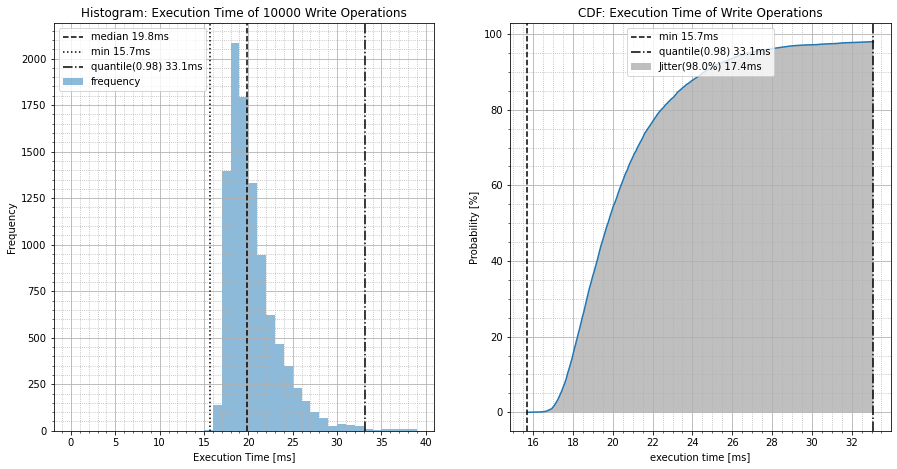

In [75]:
# method_call_ms = df_method['method_call']*10**(-6) # [ms]
# median = round(method_call_ms.median(), 1) # median
# bins = np.arange(0, 40, 1)

# fig, ax = plt.subplots(1, 2, figsize=(15,7.5))

# ax[0].hist(method_call_ms, bins=bins, alpha=0.5, label='frequency') # histogram
# ax[0].axvline(x=median, color='k', linestyle='--', label=f'median {median}ms') # draw median
# ax[0].legend()
# ax[0].set_title('Histogram of Method Call Execution Time')
# ax[0].set_xlabel('execution time [ms]')
# ax[0].set_ylabel('Frequency')
# # set grid ticks
# ax[0].yaxis.set_major_locator(MultipleLocator(250))
# ax[0].xaxis.set_major_locator(MultipleLocator(5))
# # minors relative to majors
# ax[0].xaxis.set_minor_locator(AutoMinorLocator(5))
# ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))
# ax[0].grid(which='major')
# ax[0].grid(which='minor', linestyle=':')


# cdf, steps = plot_cdf(method_call_ms, end=0.95, num=1000, plot=True) # compute CDF
# sub_window = cdf<=np.quantile(method_call_ms,0.5)
# ax[1].fill_between(cdf[sub_window], steps[sub_window]*100,
#                  color='w', hatch='//', edgecolor="k", label='<=50%')
# sub_window = (cdf>np.quantile(method_call_ms,0.5)) & (cdf<=np.quantile(method_call_ms,0.9))
# ax[1].fill_between(cdf[sub_window], steps[sub_window]*100,
#                  color='w', hatch='\\', edgecolor="k", label='<=90%')
# ax[1].legend()
# ax[1].set_title('CDF of Method Call Execution Time')
# ax[1].set_xlabel('execution time [ms]')
# ax[1].set_ylabel('Probability [%]')
# # set grid ticks
# ax[1].yaxis.set_major_locator(MultipleLocator(20))
# ax[1].xaxis.set_major_locator(MultipleLocator(2))
# # minors relative to majors
# ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].grid(which='major')
# ax[1].grid(which='minor', linestyle=':')
# plt.show()

method_call_ms = df_method['method_call']*10**(-6) # [ms]
bins = np.arange(0, 40, 1)
hist_title = f'Histogram: Execution Time of {len(method_call_ms)} Write Operations'
cdf_title = 'CDF: Execution Time of Write Operations'
hist_cdf_plot(method_call_ms, hist_title, cdf_title, bins, end=0.98)

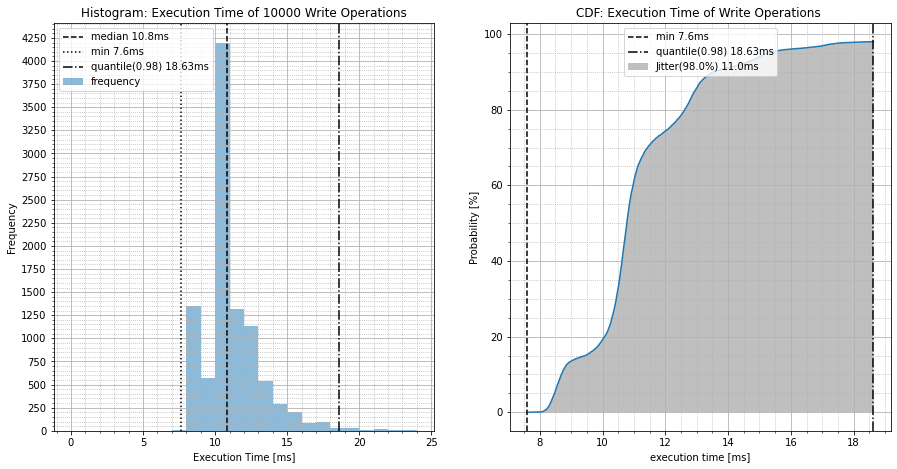

In [74]:
# write_val_ms = df_write['write_value']*10**(-6) # [ms]
# median = round(write_val_ms.median(), 1) # median
# minimum = round(write_val_ms.min(), 1)
end = 0.98
end_perc = round(np.quantile(write_val_ms,end), 2)
bins = np.arange(0, 25, 1)
hist_title = f'Histogram: Execution Time of {len(write_val_ms)} Write Operations'
cdf_title = 'CDF: Execution Time of Write Operations '


def hist_cdf_plot(data, hist_title, cdf_title, bins, end=0.98):
    median = round(data.median(), 1) # median
    minimum = round(data.min(), 1)
    end_perc = round(np.quantile(data,end), 2)
    
    fig, ax = plt.subplots(1, 2, figsize=(15,7.5))
    
    ax[0].hist(data, bins=bins, alpha=0.5, label='frequency') # histogram
    ax[0].axvline(x=median, color='k', linestyle='--', label=f'median {median}ms') # draw median
    ax[0].axvline(x=minimum, color='k', linestyle=':', label=f'min {minimum}ms') # draw Min
    ax[0].axvline(x=end_perc, color='k', linestyle='dashdot', label=f'quantile({end}) {end_perc}ms') # draw ninety_perc
    ax[0].legend(loc='upper left')
    ax[0].set_title(hist_title)
    ax[0].set_xlabel('Execution Time [ms]')
    ax[0].set_ylabel('Frequency')
    # set grid ticks
    ax[0].yaxis.set_major_locator(MultipleLocator(250))
    ax[0].xaxis.set_major_locator(MultipleLocator(5))
    # minors relative to majors
    ax[0].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0].grid(which='major')
    ax[0].grid(which='minor', linestyle=':')


    cdf, steps = plot_cdf(data, end=end, num=1000, plot=True) # compute CDF
    sub_window = cdf<=median
    # ax[1].fill_between(cdf[sub_window], steps[sub_window]*100,
    #                  color='w', hatch='//', edgecolor="k", label=f'P(t<={median}ms)=50%')
    sub_window = cdf<=end_perc #(cdf>median) & (cdf<=end_perc)
    ax[1].fill_between(cdf[sub_window], steps[sub_window]*100,
                      color='gray', alpha=0.5, hatch=None, edgecolor=None, label=f'Jitter({end*100}%) {round(end_perc-minimum,1)}ms')
    ax[1].axvline(x=minimum, color='k', linestyle='--', label=f'min {minimum}ms') # draw median
    ax[1].axvline(x=end_perc, color='k', linestyle='dashdot', label=f'quantile({end}) {end_perc}ms') # draw ninety_perc
    ax[1].legend(loc='upper center')
    ax[1].set_title(cdf_title)
    ax[1].set_xlabel('execution time [ms]')
    ax[1].set_ylabel('Probability [%]')
    # set grid ticks
    ax[1].yaxis.set_major_locator(MultipleLocator(20))
    ax[1].xaxis.set_major_locator(MultipleLocator(2))
    # minors relative to majors
    ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
    ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
    ax[1].grid(which='major')
    ax[1].grid(which='minor', linestyle=':')
    plt.show()
    
hist_cdf_plot(write_val_ms, hist_title, cdf_title, bins, end=0.98)

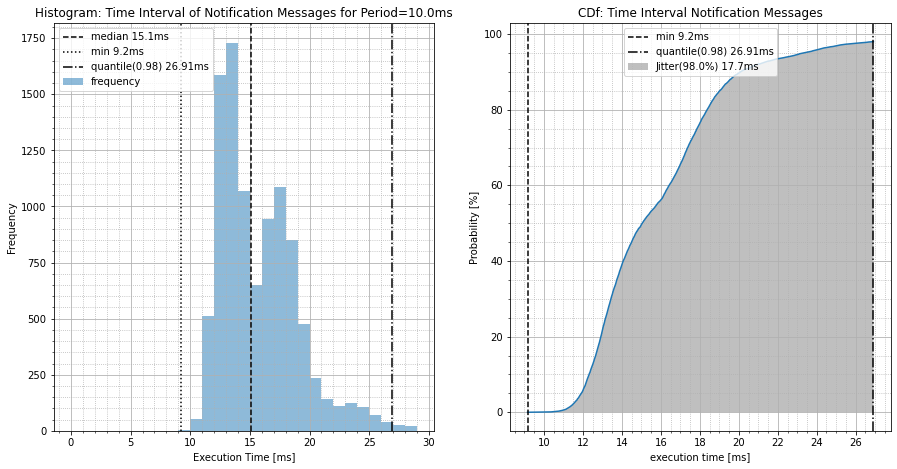

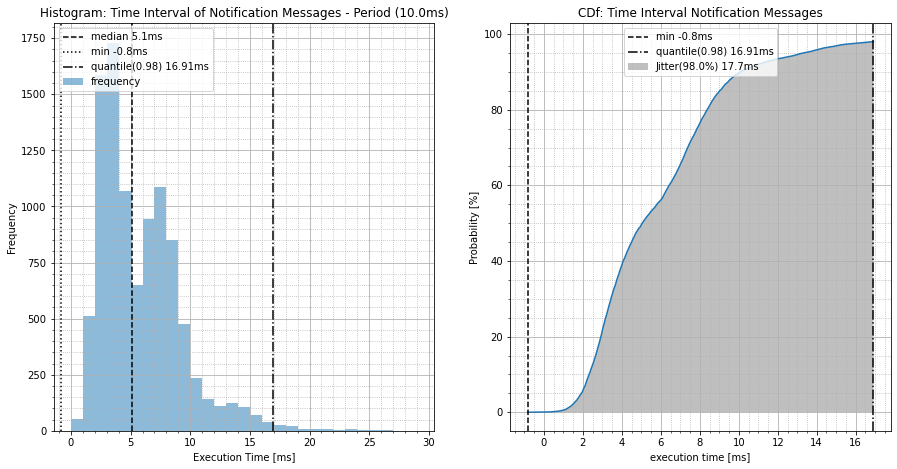

In [81]:
# notification_ms = df_sub['datachange_notifications']*10**(-6)-df_sub['period']# [ms]
# median = round(notification_ms.median(), 1) # median
# bins = np.arange(0, 30, 1)

# fig, ax = plt.subplots(1, 2, figsize=(15,7.5))

# ax[0].hist(notification_ms, bins=bins, alpha=0.5, label='frequency') # histogram
# ax[0].axvline(x=median, color='k', linestyle='--', label=f'median {median}ms') # draw median
# ax[0].legend()
# ax[0].set_title('Histogram of Notification Message Interval')
# ax[0].set_xlabel('delay-period [ms]')
# ax[0].set_ylabel('Frequency')
# # set grid ticks
# ax[0].yaxis.set_major_locator(MultipleLocator(250))
# ax[0].xaxis.set_major_locator(MultipleLocator(5))
# # minors relative to majors
# ax[0].xaxis.set_minor_locator(AutoMinorLocator(5))
# ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))
# ax[0].grid(which='major')
# ax[0].grid(which='minor', linestyle=':')


# cdf, steps = plot_cdf(notification_ms, end=0.95, num=1000, plot=True) # compute CDF
# sub_window = cdf<=np.quantile(notification_ms,0.5)
# ax[1].fill_between(cdf[sub_window], steps[sub_window]*100,
#                  color='w', hatch='//', edgecolor="k", label='<=50%')
# sub_window = (cdf>np.quantile(notification_ms,0.5)) & (cdf<=np.quantile(notification_ms,0.9))
# ax[1].fill_between(cdf[sub_window], steps[sub_window]*100,
#                  color='w', hatch='\\', edgecolor="k", label='<=90%')
# ax[1].legend()
# ax[1].set_title('CDF of Notification Message Interval')
# ax[1].set_xlabel('delay-period [ms]')
# ax[1].set_ylabel('Probability [%]')
# # set grid ticks
# ax[1].yaxis.set_major_locator(MultipleLocator(20))
# ax[1].xaxis.set_major_locator(MultipleLocator(2))
# # minors relative to majors
# ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
# ax[1].grid(which='major')
# ax[1].grid(which='minor', linestyle=':')
# plt.show()

notification_ms = df_sub['datachange_notifications']*10**(-6)# [ms]
period = df_sub['period'][0]
bins = np.arange(0, 30, 1)
hist_title = f'Histogram: Time Interval of Notification Messages for Period={period}ms'
cdf_title = 'CDf: Time Interval Notification Messages'
hist_cdf_plot(notification_ms, hist_title, cdf_title, bins, end=0.98)

notification_ms = df_sub['datachange_notifications']*10**(-6)-df_sub['period']
hist_title = f'Histogram: Time Interval of Notification Messages - Period ({period}ms)'
cdf_title = 'CDf: Time Interval Notification Messages'
hist_cdf_plot(notification_ms, hist_title, cdf_title, bins, end=0.98)